# Project 1: Quality control for a clock manufacturing company [40 marks]

---

Important information about the assignment is provided in `README.md`; read it carefully before getting started.

Run this cell first to import your modules:

In [34]:
%pip install scikit-learn
%pip install opencv-python
import sklearn
print(sklearn.__version__)  # This will print the version of scikit-learn
import sys
print(sys.executable)  # This shows the path of the Python interpreter being used

import quality_control as qc
import importlib
import numpy as np
from sklearn.linear_model import LinearRegression 
import cv2

Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 12.4 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.
1.5.2
/opt/conda/bin/python


---

There is an imaginary clock manufacturing company that wants you to develop software to check the quality of its products. The clocks produced by this company have **two hands**:

- the small hand is **red** and indicates the **hour**,
- the long hand is **green** and indicates the **minutes**.

We refer to these as *the hour hand* and *the minute hand* respectively. These clocks do not have any other hands (i.e. there is no hand for seconds).

It is very important for these hands to be **properly aligned**. For example, if the hour hand is pointing to the hour `3` (being horizontal and pointing right), the minute hand should be pointing toward the hour `12` (vertical and pointing upward). Another example is when the hour hand is pointing to the hour `1:30` (making a 45 degree angle from the vertical line), the minute hand should be pointing toward hour `6` (vertical and downward).

| Correct `1:30`, the hour hand is halfway between 1 and 2. | Incorrect `1:30`, the hour hand is too close to 1. |
|:--:|:--:|
| ![Correct 1:30](graphics/one_thirty_correct.png) | ![Incorrect 1:30](graphics/one_thirty_incorrect.png) |

Due to production imprecisions, this is not the case all the time. Your software package will **quantify the potential misalignments** and help the company to return the faulty clocks back to the production line for re-adjustment.

You will achieve this goal in several steps during this project. Most steps can be done independently. Therefore, if you are struggling with one part, you can move on to other tasks and gain the marks allocated to them.

For most tasks, under "✅ *Testing:*", you will be given instructions on how to check that your function works as it should, even if you haven't done the previous task.

---

## Task 1: Reading images into NumPy arrays [3 marks]

The company takes a picture of each clock, and saves it as a PNG image of 101x101 pixels. The folder `clock_images` contains the photos of all the clocks you need to control today. They are organised into 5 different batches for processing.

In a PNG colour image, the colour of each pixel can be represented by 3 numbers between 0 and 1, indicating respectively the amount of **red**, the amount of **green**, and the amount of **blue** needed to make this colour. This is why we refer to colour images as **RGB** images. The 3 numbers are always given in this RGB order: red, green, then blue.

- If all 3 values are 0, the pixel is black.
- If all 3 values are 1, the pixel is white.
- If all 3 values are the same, the pixel is grey. The smaller the values, the darker it is.
- Different amounts of red, green, and blue correspond to different colours.

For example, select a few colours [using this tool](https://doc.instantreality.org/tools/color_calculator/), and check the RGB values for that colour in the *RGB Normalized decimal* box. You should see that, for instance, to make yellow, we need a high value of red, a high value of green, and a low value of blue.

If you'd like more information, [this page](https://web.stanford.edu/class/cs101/image-1-introduction.html) presents a good summary about RGB images.

---

🚩 Search and study the [documentation](https://matplotlib.org/stable/) for the functions `imread()` and `imshow()` from `matplotlib.pyplot`.

Then, in `quality_control.py`, write a function `read_image(path, show=False)` which takes two input arguments:

- `path`, a string representing the relative path of a PNG image file,
- `show`, a Boolean with default value `False`.

Your function should:

- read the image file into a Numpy array with shape `(height, width, 3)` (i.e. an array which is 3 layers deep), where `height` and `width` are the number of pixel rows and columns in the image, respectively;
- if `show` is `True`, display the colour image;
- if `show` is `True`, also display all 3 layers separately;
- and return the Numpy array.

You should choose an appropriate figure layout and label your figures appropriately to clearly indicate what you are displaying. You can assume that your function will be used on image files labelled `clock_X.png`, where `X` is a number; you can use this information in your figures.

*Note: you can use `ax.imshow()` to display an image on the axes `ax`, the same way we use `ax.plot()`.*

---

✅ *Testing:* the code cell below checks that `clock_RGB` is a Numpy array with shape `(101, 101, 3)`. Running it should also display `clock_12.png` from `batch_0` as specified in the question.

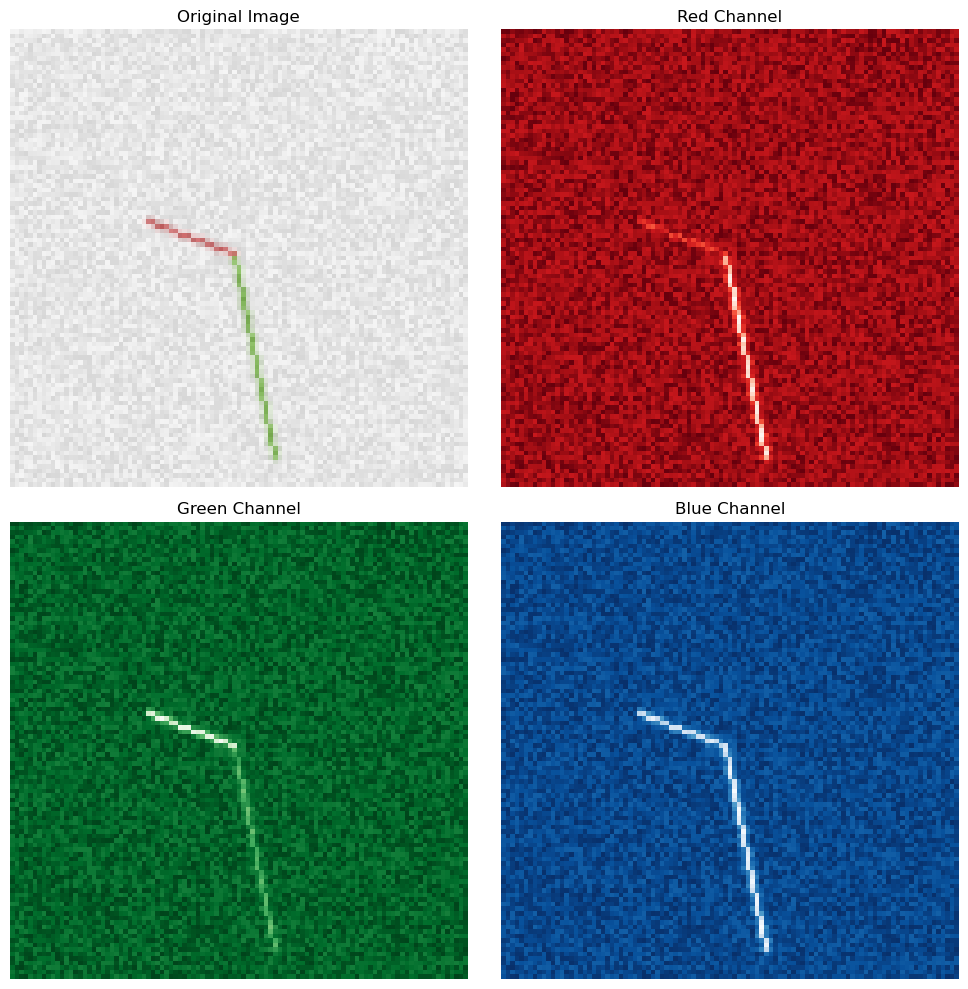

Test passed.


In [17]:
# Note: importlib.reload(qc) forces Jupyter to re-import your module (with your new changes).
importlib.reload(qc)
clock_RGB = qc.read_image('clock_images/batch_0/clock_12.png', show=True)
assert isinstance(clock_RGB, np.ndarray)
assert clock_RGB.shape == (101, 101, 3)
print('Test passed.')

---
## Task 2: Clean up the images to extract data [8 marks]

Later in Task 3, we will use **linear regression** to find the exact position of both clock hands. To perform linear regression, we will need the **coordinates of the pixels** belonging to each hand; then, we will be able to fit a line through these pixels.

This task is concerned with extracting the correct pixel coordinates from the image.

---

🚩 Write a function `get_clock_hands(clock_RGB)`, which takes one input argument `clock_RGB`, a NumPy array of size 101x101x3 representing an RGB image of a clock (such as that returned by `read_image()`), and returns 2 NumPy arrays with 2 columns each, such that:

- In the first array, each row corresponds to the `[row, column]` indices of a pixel belonging to the **hour hand**.
- In the second array, each row corresponds to the `[row, column]` indices of a pixel belonging the **minute hand**.

The goal is to obtain, for each hand, a collection of `[row, column]` coordinates which indicate where on the picture is the clock hand. **You will need to figure out a way to decide** whether a given pixel belongs to the hour hand, the minute hand, or neither.

---

***Important note:*** the pictures all contain some amount of noise and blur. Depending on how you decide to count a certain pixel or not as part of a clock hand, your function will pick up different pixels. There isn't just one possible set of pixel coordinates to pick up for a given image -- the most important thing is that the pixels you extract **only** belong to one of the two hands, and not to the background for example. This will ensure that you can use linear regression effectively.

---

✅ *Testing:* For example, for the tiny 7x7 clock below, this is what you should get (a 7x7 pixel image is available in the `testing` folder for you to try your function):

| Clock | Hour hand | Minute hand |
|:--:|:--:|:--:|
| <img src="graphics/task2.png" alt="Task 2 example" style="width: 100px;"/> | [[1, 1]<br/> [2, 2]] | [[3, 3]<br/> [4, 3]<br/> [4, 4]<br/> [5, 4]<br/> [6, 5]] |

Keep in mind that the real images are noisy/blurry, so make sure you test your function on some of the real images too. To do this, you may wish to write code to display what pixels you've extracted -- this could be e.g. a black-and-white image with a black background, and the pixels you extracted from each hand shown in white.

In [87]:
importlib.reload(qc)

clock_RGB = qc.read_image('testing/task2_7x7.png')

# Use this instead in case your read_image() function is not working
# clock_RGB = np.load('testing/task2_7x7.npy')

hour_pixels, minute_pixels = qc.get_clock_hands(clock_RGB)

np.testing.assert_equal(hour_pixels, np.array([[1, 1], [2, 2]]))
np.testing.assert_equal(minute_pixels, np.array([[3, 3], [4, 3], [4, 4], [5, 4], [6, 5]]))

print('Test passed.')

Test passed.


---

## Task 3: Calculate the angle of the two hands [8 marks]

Now that we have pixel locations for each hand, we can estimate the **angle** between each hand and the 12 o'clock position. We will use this angle later to determine the time indicated by each hand. For instance, the figure below shows the angle made by the hour hand with the 12 o'clock position.

![Angle between hour hand and 12 o'clock](graphics/angle.png)

---

🚩 Write a function `get_angle(coords)` which takes one input argument, a NumPy array with 2 columns representing `[row, column]` pixel coordinates of one clock hand, exactly like one of the arrays returned by `get_clock_hands()` from Task 2.

- Your function should use these pixel coordinates to find a **line of best fit** using linear regression.
- Then, using this line of best fit, you should determine and **return** the angle between the clock hand and the 12 o'clock position, measured in **radians**.

The angle should take a value between $0$ (inclusive) and $2\pi$ (exclusive) radians, where $0\, \text{rad}$ corresponds to the 12 o'clock position.

---

***Notes:***

- When performing linear regression, you will need to pay particular attention to the case where the clock hand is vertical or almost vertical.
- Beware of the correspondance between `[row, column]` index and `(x, y)` coordinate for a given pixel.
- Note that the meeting point of the 2 clock hands may not be exactly at `[50, 50]`. Some of the pictures have a small offset.
- Partial attempts will receive partial marks. For instance, if you are struggling with using linear regression, or if you don't know how to account for possible offset of the centre, you may receive partial marks if you use a simpler (but perhaps less accurate) method.

---

✅ *Testing:* the files `task3_hourhand.txt` and `task3_minutehand.txt` are provided for you to test your function in the `testing` folder. Use `np.loadtxt()` to read them.

With these coordinates, you should find an angle of approximately 2 radians for the hour hand, and 5.4 radians for the minute hand.

In [106]:
importlib.reload(qc)
hour_pixels = np.loadtxt('testing/task3_hourhand.txt')
minute_pixels = np.loadtxt('testing/task3_minutehand.txt')

angle_hour = qc.get_angle(hour_pixels)
angle_minute = qc.get_angle(minute_pixels)

assert round(angle_hour, 1) == 2.0, f"Expected 2.0 but got {round(angle_hour, 1)}"
assert round(angle_minute, 1) == 5.4,  f"Expected 5.4 but got {round(angle_minute, 1)}"
print('Test passed.')

AssertionError: Expected 2.0 but got 2.3

---
## Task 4: Analog to digital conversion [5 marks]

🚩 Write a function `analog_to_digital(angle_hour, angle_minute)` that takes two input arguments, corresponding to the angles formed by each hand with 12 o'clock, and returns the time in digital format, as a string.

More specifically, the output should be a string showing the time in hours and minutes in the format `hh:mm`, where `hh` is the hour and `mm` is the minute.

- When the hours or minutes are smaller than 10, add a leading zero (e.g. `04:30`, `11:02`).
- When the hour is zero, use `12` (e.g. return `12:30` rather than `00:30`).

(At this point, your function is not concerned about the imprecision. It should calculate the hour from the hour hand, and the minute from the minute hand, separately.)

---
✅ *Testing:* with `angle_hour` set to $\frac{\pi}{3}$ and `angle_minute` set to $\frac{11\pi}{6}$, you should get `02:55`.

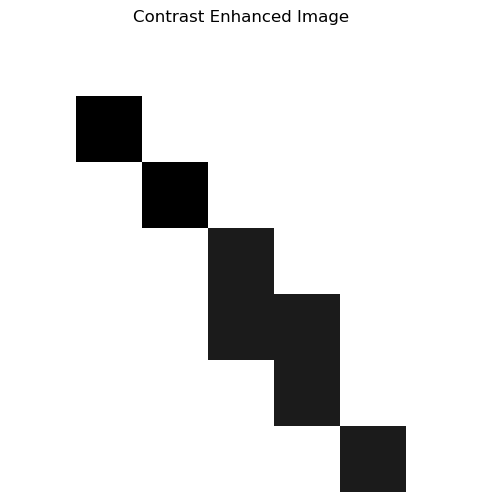

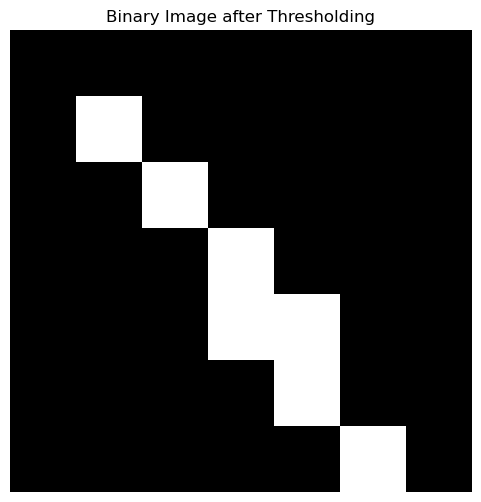

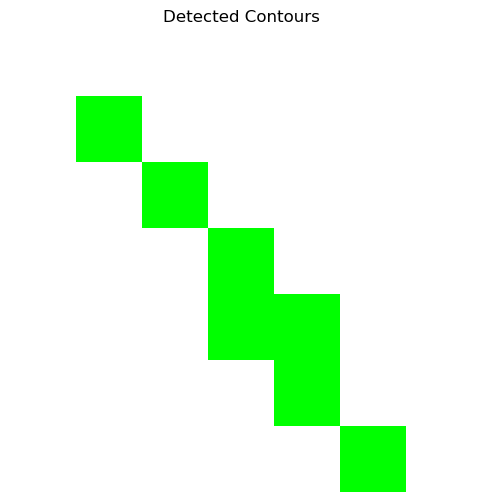

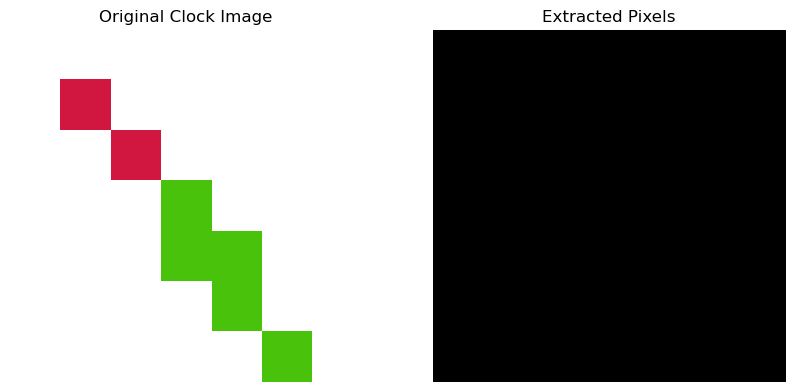

Test passed.


In [81]:
importlib.reload(qc)

angle_hour = np.pi / 3
angle_minute = 11 * np.pi / 6
digital_time = qc.analog_to_digital(angle_hour, angle_minute)
assert digital_time == '02:55', f"Expected '02:55' but got '{digital_time}'"
print('Test passed.')

---
## Task 5: Find the misalignment [5 marks]

Now that you have extracted useful information from the pictures, you need to check if the two hands are aligned properly. To do so, you will need to find the exact time that the **hour hand alone** is showing, in hours and minutes. Then, **compare with the minutes that the minute hand is showing**, and report the difference.

Note that the misalignment will never be more than 30 minutes. For example, if you read a 45-minute difference between the minutes indicated by the hour hand and the minute hand, you could realign the minute hand by 15 minutes in the other direction instead.

---

🚩 Write a function `check_alignment(angle_hour, angle_minute)` which returns the misalignment in minutes.

- The misalignment should be **positive** when the minute hand is **ahead** of where it should be.
- The misalignment should be **negative** when the minute hand is **behind** where it should be.

Make sure you structure you code sensibly. You may wish to write some intermediate functions to do the sub-tasks.

---
✅ *Testing:* the same angles as in Task 4 should give you a -5 minute misalignment.

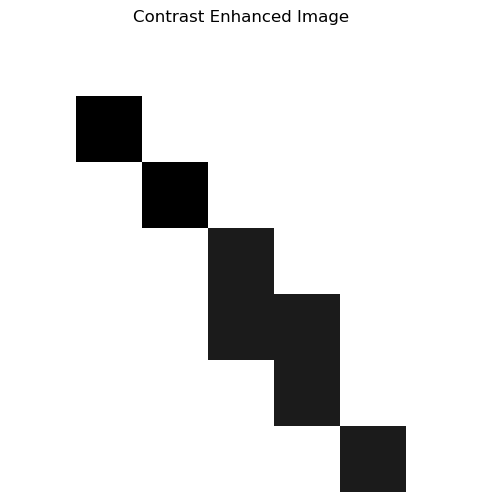

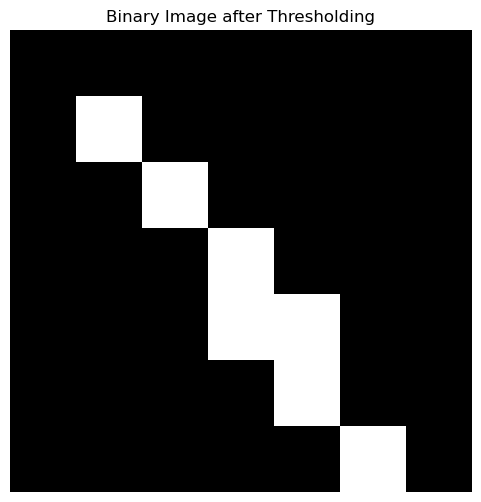

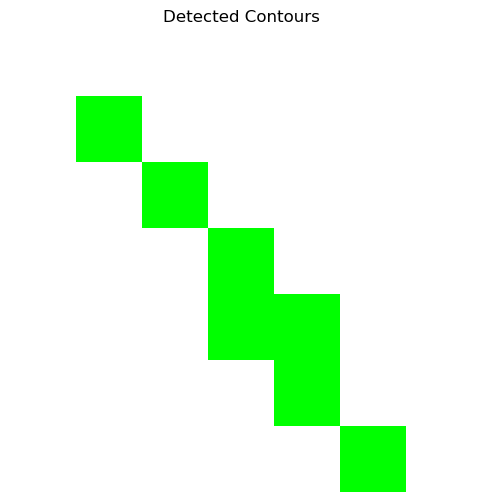

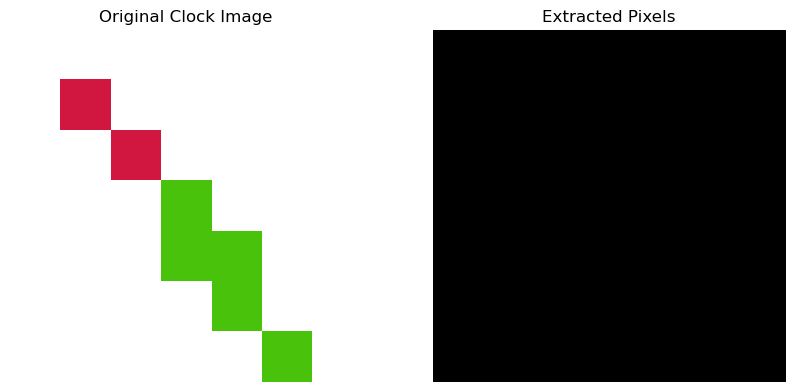

Test passed.


In [80]:
importlib.reload(qc);
diff = qc.check_alignment(np.pi/3, 11*np.pi/6)
assert diff == -5
print('Test passed.')

---
## Task 6: Reporting to the quality team [6 marks]

Now that you have successfully broken down the problem into a sequence of sub-tasks, you need to combine all the above steps in one function. As before, you may wish to write intermediate functions to do different parts.

---

🚩 Write a function `validate_batch(folder_path, tolerance)` which takes 2 input arguments:

- `folder_path`, a string to indicate the path of a **folder** containing a batch of clock pictures,
- `tolerance`, a positive integer representing the maximum tolerable number of minutes of misalignment for a clock to pass the quality control check.

Your `validate_batch()` function should write a `.txt` file called `batch_X_QC.txt` (where `X` should be replaced by the batch number), containing the following information:

```
Batch number: [X]
Checked on [date and time]

Total number of clocks: [X]
Number of clocks passing quality control ([X]-minute tolerance): [X]
Batch quality: [X]%

Clocks to send back for readjustment:
clock_[X]   [X]min
clock_[X]   [X]min
clock_[X]   [X]min
[etc.]
```

The square brackets indicate information which you need to fill in.

- You will need to check all pictures in the given folder. You may wish to use Python's `os` or `pathlib` modules.
- The date and time should be the exact date and time at which you performed the validation (i.e. at which you ran the code), in the format `YYYY-MM-DD, hh:mm:ss`. You may wish to use Python's `datetime` module.
- The batch quality is the percentage of clocks which passed the quality control in the batch, given to 1 decimal place. For example, in a batch of 20 clocks, if 15 passed the control and 5 failed, the batch quality is `75.0%`.
- List all clock numbers which should be sent back for realignment, in **decreasing order of absolute misalignment**. That is, the most misaligned clock (in either direction) should appear first.
- Misalignments should be displayed with a **sign**. For example, a positive 6 minute misalignment should be displayed as `+6min`.
- The list of clocks to send back and the misalignment in minutes should be vertically aligned, in a way which makes the report easy to read. Check the example in the `testing` folder; note that the misalignments in minutes are right-aligned.
- Your function should not return anything, simply write the `.txt` report and save it to a folder called `QC_reports`, which (for full marks) you should create using Python if it doesn't exist.

For instance, to use your function to check batch 1 with a 2-minute maximum acceptable misalignment, the command will be `validate_batch('clock_images/batch_1', 2)`.

---

✅ *Testing:* There is an example report in the `testing` folder (for a batch which you do not have), to check that your report is formatted correctly.

Running the code cell below should create reports in the correct folder for all 5 batches, with a tolerance of 4 minutes.

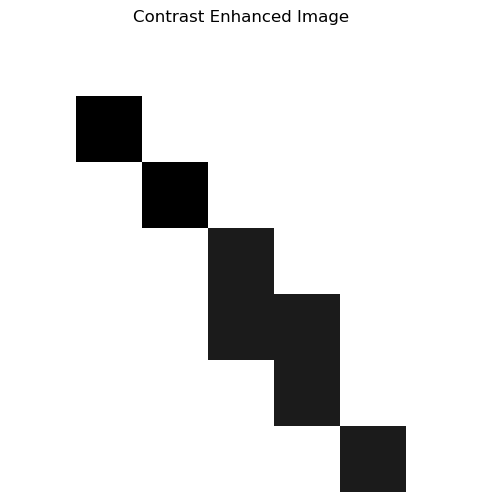

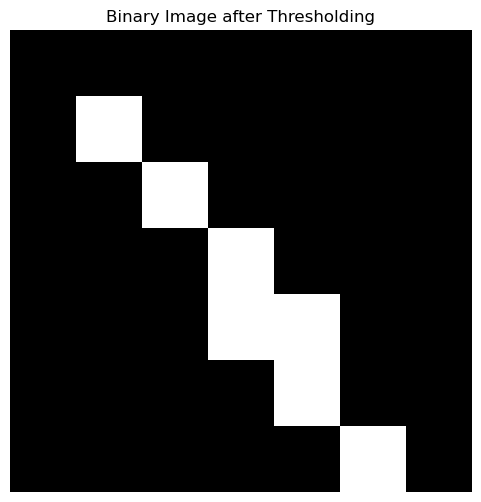

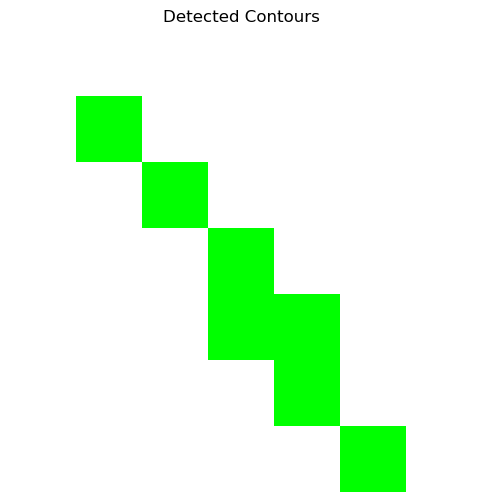

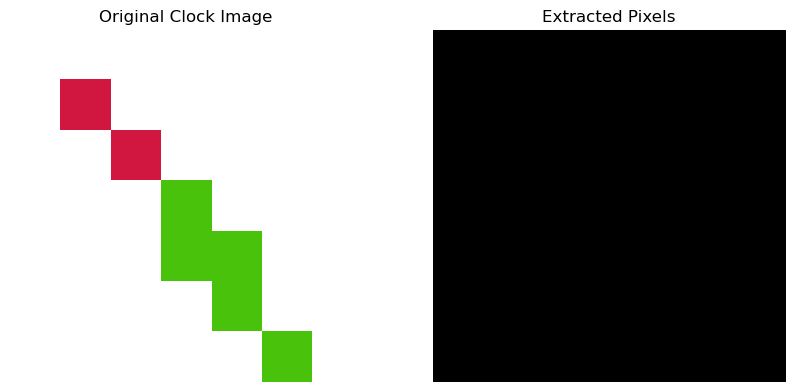

In [82]:
importlib.reload(qc);
for b in range(5):
    qc.validate_batch(f'clock_images/batch_{b}', 4)

---
## Task 7: Finding coupling faults [5 marks]

There is another issue which can affect the clocks: the hour and minute hands may not be coupled properly, leading to the **minute hand going faster or slower than it should** (compared to the hour hand).

To spot this issue, we can take a picture of the same clock, at two different times. Assuming that the hour hand turns at the correct speed, if the **misalignment of the minute hand has grown or decreased** between the two pictures, then the clock has a coupling problem.

---

🚩 Write a function `check_coupling(path_1, path_2)` which takes 2 input arguments `path_1` and `path_2`, both strings representing the relative path of two PNG image files. We assume that:

- The two pictures are of the **same clock**, and were taken some time apart.
- `path_1` was taken **before** `path_2`.
- The second picture was taken **at most 12 hours after** the first one.

Your function should compute how much time the minute hand gains or loses **per hour**, expressed in minutes and seconds, and **return a string** as described below:

- If there is no evidence of decoupling (i.e. if the misalignments are the same between the two pictures), your function should return: `'The hour and minute hand are coupled properly.'`
- If the minute hand is going too fast, your function should return: `'The minute hand gains X minutes, Y seconds per hour.'`, with `X` and `Y` replaced respectively by the number of minutes and seconds gained per hour.
- If the minute hand is going too slow, your function should return: `'The minute hand loses X minutes, Y seconds per hour.'`, with `X` and `Y` replaced respectively by the number of minutes and seconds lost per hour.


---

✅ *Testing:* running the code cell below using clocks 14 and 21 from batch 1 should show that the minute hand gains 12 minutes each hour.

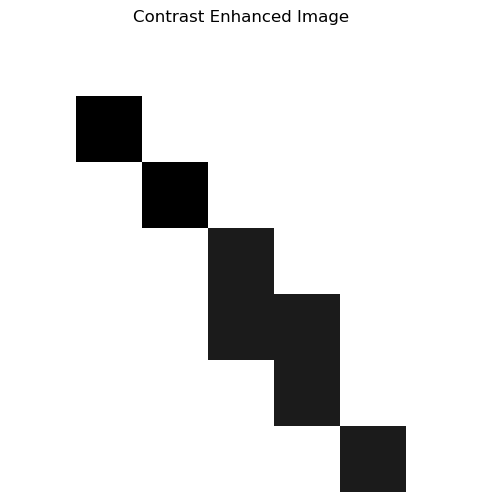

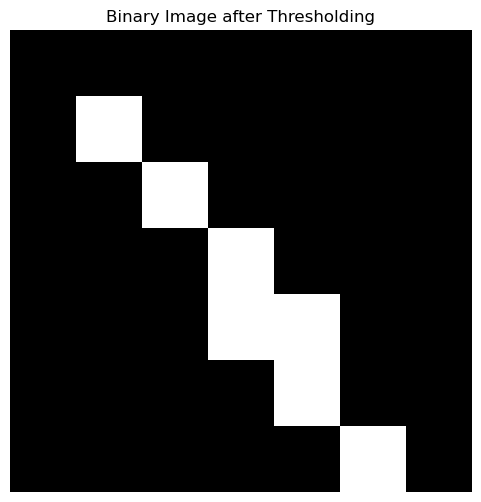

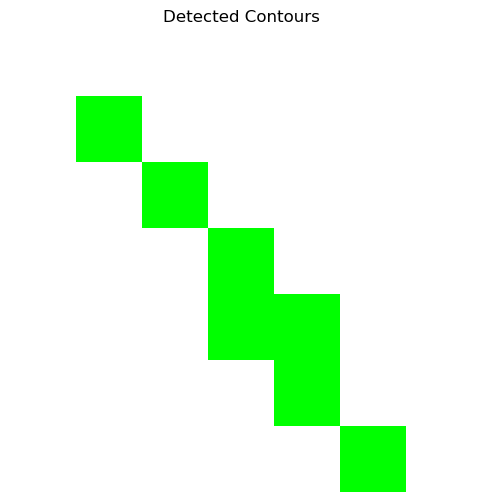

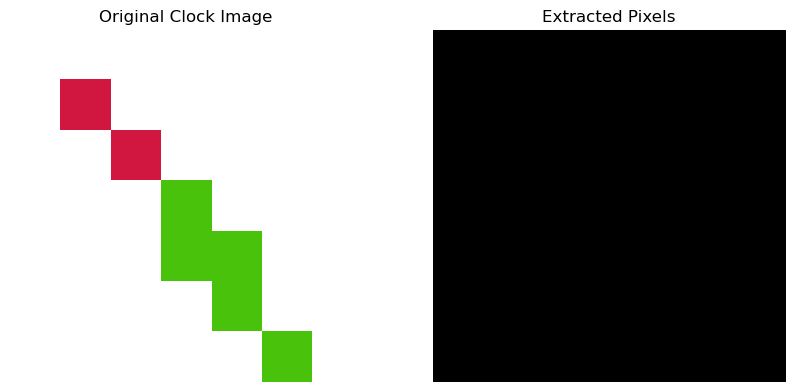

The minute hand gains 0 minutes, 35 seconds per hour.


In [83]:
importlib.reload(qc);
coupling_output = qc.check_coupling('clock_images/batch_1/clock_14.png',
                                    'clock_images/batch_1/clock_21.png')
print(coupling_output)